Epoch 1/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 84ms/step - loss: 3.2702 - val_loss: 0.0949
Epoch 2/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 47ms/step - loss: 0.1575 - val_loss: 0.0196
Epoch 3/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 44ms/step - loss: 0.1199 - val_loss: 0.0544
Epoch 4/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 45ms/step - loss: 0.1058 - val_loss: 0.0317
Epoch 5/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 43ms/step - loss: 0.0771 - val_loss: 0.0466
Epoch 6/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 44ms/step - loss: 0.0700 - val_loss: 0.0259
Epoch 7/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 75ms/step - loss: 0.0698 - val_loss: 0.0757
Epoch 8/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 48ms/step - loss: 0.0494 - val_loss:

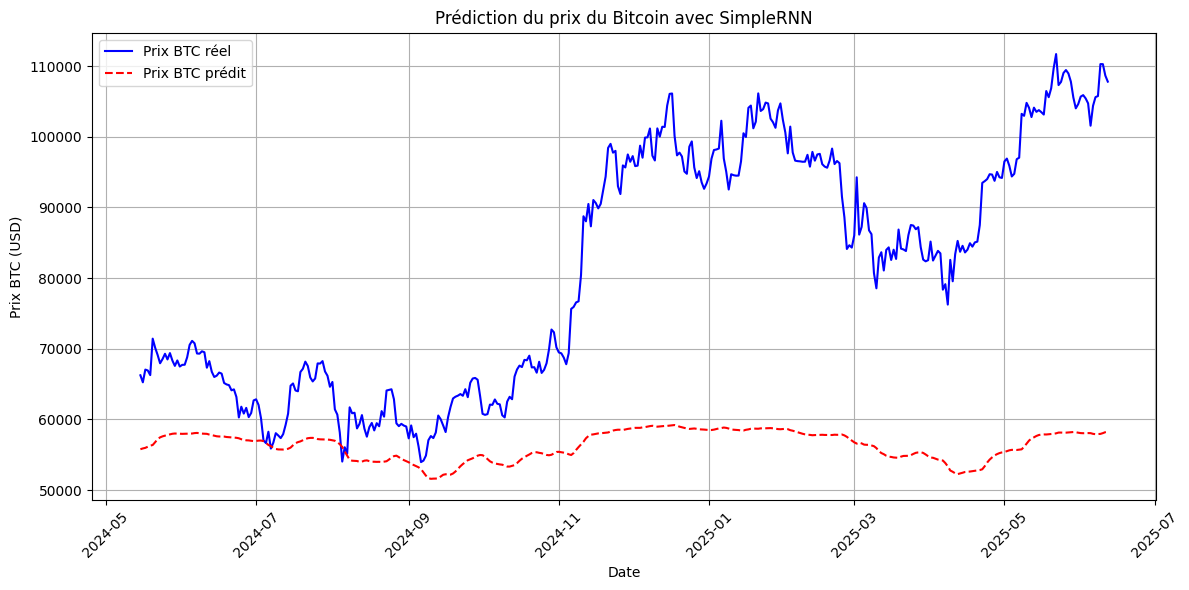

‚úÖ Mod√®le sauvegard√© sous le nom 'best_rnn_model.h5'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
from keras.models import Sequential
from keras.layers import SimpleRNN, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import requests

# ---------- 1. Collecte des donn√©es ----------
def collect_data_crypto_compare(crypto_symbol, start_timestamp, end_timestamp):
    url = f'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': crypto_symbol,
        'tsym': 'USD',
        'limit': 2000,
        'toTs': end_timestamp,
        'extraParams': 'crypto_prediction'
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['Data']['Data']
        df = pd.DataFrame(data)
        df['time'] = pd.to_datetime(df['time'], unit='s')
        return df
    else:
        print(f"Erreur lors de la r√©cup√©ration des donn√©es : {response.status_code}")
        return None

# ---------- 2. Pr√©traitement ----------
def preprocess_data(btc_df, eth_df):
    df = pd.merge(btc_df[['time', 'close']], eth_df[['time', 'close']], on='time', suffixes=('_btc', '_eth'))
    df = df.sort_values('time')
    df['btc_return'] = df['close_btc'].pct_change()
    df['eth_return'] = df['close_eth'].pct_change()
    df.dropna(inplace=True)
    return df

# ---------- 3. Cr√©ation des s√©quences ----------
def create_sequences(eth_prices, btc_prices, seq_length):
    X, y = [], []
    for i in range(len(eth_prices) - seq_length):
        X.append(np.column_stack((eth_prices[i:i+seq_length], btc_prices[i:i+seq_length])))
        y.append(btc_prices[i+seq_length])
    return np.array(X), np.array(y)

# ---------- 4. Construction du mod√®le RNN ----------
def build_rnn_model(seq_length, units=128, dropout=0.1, learning_rate=0.01):
    model = Sequential()
    model.add(SimpleRNN(units=units, return_sequences=True, input_shape=(seq_length, 2)))
    model.add(Dropout(dropout))
    model.add(SimpleRNN(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(SimpleRNN(units=units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# ---------- 5. Entra√Ænement et √âvaluation ----------
def train_rnn_model(data, seq_length=32, units=128, dropout=0.1, learning_rate=0.01):
    eth_scaler = MinMaxScaler()
    btc_scaler = MinMaxScaler()
    eth_scaled = eth_scaler.fit_transform(data[['close_eth']])
    btc_scaled = btc_scaler.fit_transform(data[['close_btc']])

    X, y = create_sequences(eth_scaled, btc_scaled, seq_length)
    X = X.reshape((X.shape[0], X.shape[1], 2))

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = build_rnn_model(seq_length, units, dropout, learning_rate)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    y_pred = model.predict(X_test)
    y_test_inv = btc_scaler.inverse_transform(y_test)
    y_pred_inv = btc_scaler.inverse_transform(y_pred)

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inv, y_pred_inv)

    print(f"\n√âvaluation finale du mod√®le RNN :")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R¬≤   : {r2:.4f}")

    # Visualisation
    test_dates = data['time'].iloc[-len(y_test):].values
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test_inv, label='Prix BTC r√©el', color='blue')
    plt.plot(test_dates, y_pred_inv, label='Prix BTC pr√©dit', color='red', linestyle='--')
    plt.title('Pr√©diction du prix du Bitcoin avec SimpleRNN')
    plt.xlabel('Date')
    plt.ylabel('Prix BTC (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Sauvegarde
    model.save("best_rnn_model.h5")
    print("‚úÖ Mod√®le sauvegard√© sous le nom 'best_rnn_model.h5'")
    return model

# ---------- 6. Ex√©cution ----------
if __name__ == "__main__":
    today = datetime.today()
    end_timestamp = int(time.mktime(today.timetuple()))
    start_timestamp = 1614556800  # 1 mars 2021

    btc_data = collect_data_crypto_compare('BTC', start_timestamp, end_timestamp)
    eth_data = collect_data_crypto_compare('ETH', start_timestamp, end_timestamp)

    if btc_data is not None and eth_data is not None:
        data = preprocess_data(btc_data, eth_data)
        model = train_rnn_model(data)
    else:
        print("‚ùå Les donn√©es n'ont pas pu √™tre r√©cup√©r√©es.")


Epoch 1/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 182ms/step - loss: 0.5549 - val_loss: 0.0039
Epoch 2/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 142ms/step - loss: 0.0020 - val_loss: 7.7494e-04
Epoch 3/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 168ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 4/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 173ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 5/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 163ms/step - loss: 9.7662e-04 - val_loss: 0.0015
Epoch 6/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 143ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 7/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 142ms/step - loss: 0.0018 - val_loss: 4.7775e-04
Epoch 8/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 147ms/step 

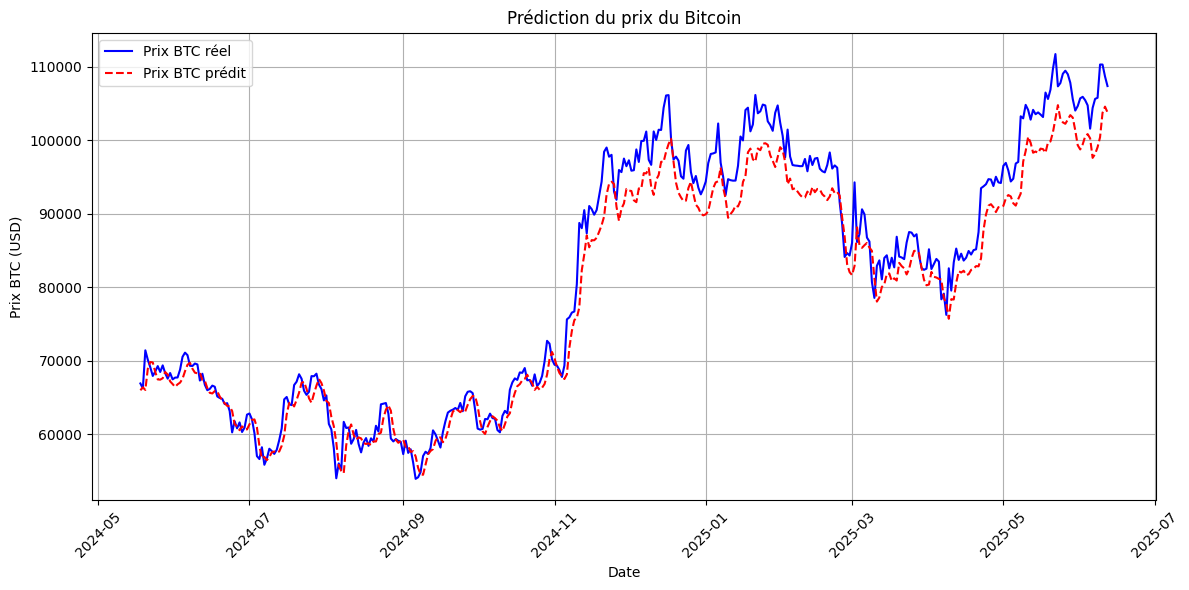

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import time
from datetime import datetime
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import requests

# Fonction de r√©cup√©ration de donn√©es (inchang√©e)
def collect_data_crypto_compare(crypto_symbol, start_timestamp, end_timestamp):
    url = f'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': crypto_symbol,
        'tsym': 'USD',
        'limit': 2000,
        'toTs': end_timestamp,
        'extraParams': 'crypto_prediction'
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()['Data']['Data']
        df = pd.DataFrame(data)
        df['time'] = pd.to_datetime(df['time'], unit='s')
        return df
    else:
        print(f"Erreur lors de la r√©cup√©ration des donn√©es: {response.status_code}")
        return None

# Pr√©traitement
def preprocess_data(btc_df, eth_df):
    df = pd.merge(btc_df[['time', 'close']], eth_df[['time', 'close']], on='time', suffixes=('_btc', '_eth'))
    df = df.sort_values('time')
    df['btc_return'] = df['close_btc'].pct_change()
    df['eth_return'] = df['close_eth'].pct_change()
    df.dropna(inplace=True)
    return df

# Cr√©ation des s√©quences
def create_sequences(eth_prices, btc_prices, seq_length=30):
    X, y = [], []
    for i in range(len(eth_prices) - seq_length):
        X.append(np.column_stack((eth_prices[i:i+seq_length], btc_prices[i:i+seq_length])))
        y.append(btc_prices[i+seq_length])
    return np.array(X), np.array(y)

# Construction du mod√®le
def build_gru_model(seq_length, units, dropout_rate, learning_rate):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(seq_length, 2)),
        Dropout(dropout_rate),
        LSTM(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Entra√Ænement avec les meilleurs param√®tres
def train_best_gru_model_fixed(data):
    best_params = {
        'seq_length': 45,
        'units': 128,
        'dropout': 0.2,
        'learning_rate': 0.01
    }

    eth_scaler = MinMaxScaler()
    btc_scaler = MinMaxScaler()
    eth_scaled = eth_scaler.fit_transform(data[['close_eth']])
    btc_scaled = btc_scaler.fit_transform(data[['close_btc']])

    X, y = create_sequences(eth_scaled, btc_scaled, best_params['seq_length'])
    X = X.reshape((X.shape[0], X.shape[1], 2))

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = build_gru_model(
        best_params['seq_length'],
        best_params['units'],
        best_params['dropout'],
        best_params['learning_rate']
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=100, batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    gru_pred = model.predict(X_test)
    y_test_btc = btc_scaler.inverse_transform(y_test)
    gru_pred_btc = btc_scaler.inverse_transform(gru_pred)

    mse = mean_squared_error(y_test_btc, gru_pred_btc)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_btc, gru_pred_btc)

    print(f"\n‚úÖ √âvaluation finale du mod√®le :\nMSE : {mse:.2f}, RMSE : {rmse:.2f}, R¬≤ : {r2:.4f}")

    # Visualisation
    test_dates = data['time'].iloc[-len(y_test):].values
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test_btc, label='Prix BTC r√©el', color='blue')
    plt.plot(test_dates, gru_pred_btc, label='Prix BTC pr√©dit', color='red', linestyle='--')
    plt.title('Pr√©diction du prix du Bitcoin')
    plt.xlabel('Date')
    plt.ylabel('Prix BTC (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Sauvegarde du mod√®le
    model.save("best_lstm_modele.h5")

    return model, eth_scaler, btc_scaler

# Utilisation
today = datetime.today()
end_timestamp = int(time.mktime(today.timetuple()))
start_timestamp = 1614556800  # 1er mars 2021

btc_data = collect_data_crypto_compare('BTC', start_timestamp, end_timestamp)
eth_data = collect_data_crypto_compare('ETH', start_timestamp, end_timestamp)

if btc_data is not None and eth_data is not None:
    data = preprocess_data(btc_data, eth_data)
    model, eth_scaler, btc_scaler = train_best_gru_model_fixed(data)
else:
    print("‚ùå Erreur : Les donn√©es n'ont pas pu √™tre r√©cup√©r√©es.")



üîç Total de combinaisons √† tester : 81

‚ú™ Test 1/81: seq=15, units=32, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.002821

‚ú™ Test 2/81: seq=15, units=32, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.002470

‚ú™ Test 3/81: seq=15, units=32, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001787

‚ú™ Test 4/81: seq=15, units=32, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001511

‚ú™ Test 5/81: seq=15, units=32, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001447

‚ú™ Test 6/81: seq=15, units=32, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001586

‚ú™ Test 7/81: seq=15, units=32, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.005625

‚ú™ Test 8/81: seq=15, units=32, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.002437

‚ú™ Test 9/81: seq=15, units=32, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001968

‚ú™ Test 10/81: seq=15, units=64, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000708

‚ú™ Test 11/81: seq=15, units=64, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001106

‚ú™ Test 12/81: seq=15, units=64, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001490

‚ú™ Test 13/81: seq=15, units=64, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001004

‚ú™ Test 14/81: seq=15, units=64, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001068

‚ú™ Test 15/81: seq=15, units=64, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.002101

‚ú™ Test 16/81: seq=15, units=64, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001948

‚ú™ Test 17/81: seq=15, units=64, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001023

‚ú™ Test 18/81: seq=15, units=64, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001495

‚ú™ Test 19/81: seq=15, units=128, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000726

‚ú™ Test 20/81: seq=15, units=128, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000620

‚ú™ Test 21/81: seq=15, units=128, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001951

‚ú™ Test 22/81: seq=15, units=128, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000759

‚ú™ Test 23/81: seq=15, units=128, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000777

‚ú™ Test 24/81: seq=15, units=128, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.004328

‚ú™ Test 25/81: seq=15, units=128, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.002049

‚ú™ Test 26/81: seq=15, units=128, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001201

‚ú™ Test 27/81: seq=15, units=128, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001512

‚ú™ Test 28/81: seq=30, units=32, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000787

‚ú™ Test 29/81: seq=30, units=32, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001449

‚ú™ Test 30/81: seq=30, units=32, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.002452

‚ú™ Test 31/81: seq=30, units=32, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.003100

‚ú™ Test 32/81: seq=30, units=32, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001594

‚ú™ Test 33/81: seq=30, units=32, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001866

‚ú™ Test 34/81: seq=30, units=32, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.002513

‚ú™ Test 35/81: seq=30, units=32, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.002442

‚ú™ Test 36/81: seq=30, units=32, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.002059

‚ú™ Test 37/81: seq=30, units=64, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000678

‚ú™ Test 38/81: seq=30, units=64, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001378

‚ú™ Test 39/81: seq=30, units=64, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001947

‚ú™ Test 40/81: seq=30, units=64, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000987

‚ú™ Test 41/81: seq=30, units=64, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001225

‚ú™ Test 42/81: seq=30, units=64, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001806

‚ú™ Test 43/81: seq=30, units=64, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001142

‚ú™ Test 44/81: seq=30, units=64, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001033

‚ú™ Test 45/81: seq=30, units=64, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001598

‚ú™ Test 46/81: seq=30, units=128, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000757

‚ú™ Test 47/81: seq=30, units=128, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000996

‚ú™ Test 48/81: seq=30, units=128, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000991

‚ú™ Test 49/81: seq=30, units=128, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000871

‚ú™ Test 50/81: seq=30, units=128, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000784

‚ú™ Test 51/81: seq=30, units=128, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000929

‚ú™ Test 52/81: seq=30, units=128, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001827

‚ú™ Test 53/81: seq=30, units=128, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001116

‚ú™ Test 54/81: seq=30, units=128, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001360

‚ú™ Test 55/81: seq=45, units=32, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000862

‚ú™ Test 56/81: seq=45, units=32, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001646

‚ú™ Test 57/81: seq=45, units=32, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001883

‚ú™ Test 58/81: seq=45, units=32, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001795

‚ú™ Test 59/81: seq=45, units=32, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001619

‚ú™ Test 60/81: seq=45, units=32, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.002064

‚ú™ Test 61/81: seq=45, units=32, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.003861

‚ú™ Test 62/81: seq=45, units=32, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001306

‚ú™ Test 63/81: seq=45, units=32, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.002041

‚ú™ Test 64/81: seq=45, units=64, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000804

‚ú™ Test 65/81: seq=45, units=64, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000917

‚ú™ Test 66/81: seq=45, units=64, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.002049

‚ú™ Test 67/81: seq=45, units=64, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001704

‚ú™ Test 68/81: seq=45, units=64, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000898

‚ú™ Test 69/81: seq=45, units=64, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.002522

‚ú™ Test 70/81: seq=45, units=64, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000891

‚ú™ Test 71/81: seq=45, units=64, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001280

‚ú™ Test 72/81: seq=45, units=64, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001703

‚ú™ Test 73/81: seq=45, units=128, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000623

‚ú™ Test 74/81: seq=45, units=128, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000879

‚ú™ Test 75/81: seq=45, units=128, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001159

‚ú™ Test 76/81: seq=45, units=128, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000606

‚ú™ Test 77/81: seq=45, units=128, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000945

‚ú™ Test 78/81: seq=45, units=128, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000959

‚ú™ Test 79/81: seq=45, units=128, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000750

‚ú™ Test 80/81: seq=45, units=128, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000814

‚ú™ Test 81/81: seq=45, units=128, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001387

‚úÖ Meilleure configuration trouv√©e : {'seq_length': 45, 'units': 128, 'dropout': 0.2, 'learning_rate': 0.01}
üìä Score MSE moyen : 0.000606
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 144ms/step - loss: 0.0657 - val_loss: 8.1339e-04
Epoch 2/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 138ms/step - loss: 0.0018 - val_loss: 7.2771e-04
Epoch 3/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 166ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 4/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 168ms/step - loss: 8.9954e-04 - val_loss: 0.0011
Epoch 5/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 129ms/step - loss: 7.8725e-04 - val_loss: 9.2125e-04
Epoch 6/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 131ms/step - loss: 6.7792e-04 - val_loss: 4.7118e-04
Epoch 7/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 131ms/step - loss: 5.7285e-04 - val_loss: 3.3875e-04
Epoch 8/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10

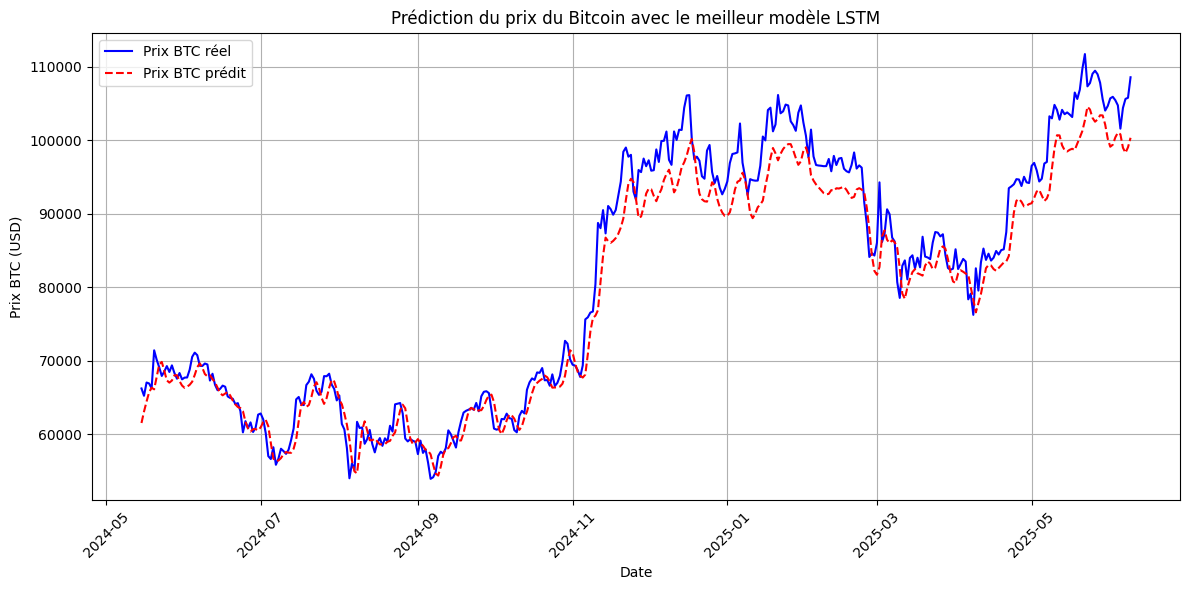

In [ ]:
# Ajout complet avec recherche automatique d'hyperparam√®tres (grid search), entrainement du meilleur mod√®le, et visualisation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import time
from datetime import datetime
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import itertools
import requests

# Fonctions inchang√©es pour la cr√©ation des s√©quences et le mod√®le
def collect_data_crypto_compare(crypto_symbol, start_timestamp, end_timestamp):
    url = f'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': crypto_symbol,  # Symbole de la cryptomonnaie (BTC ou ETH)
        'tsym': 'USD',  # Devise de comparaison
        'limit': 2000,  # Limite des jours √† r√©cup√©rer
        'toTs': end_timestamp,  # Timestamp de fin
        'extraParams': 'crypto_prediction'  # Param√®tre optionnel pour l'identification de l'application
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()['Data']['Data']
        df = pd.DataFrame(data)

        # Convertir les timestamps en dates lisibles
        df['time'] = pd.to_datetime(df['time'], unit='s')

        return df
    else:
        print(f"Erreur lors de la r√©cup√©ration des donn√©es: {response.status_code}")
        return None

# Fonction pour pr√©traiter les donn√©es
def preprocess_data(btc_df, eth_df):
    # Fusionner les donn√©es BTC et ETH sur la colonne 'time'
    df = pd.merge(btc_df[['time', 'close']], eth_df[['time', 'close']], on='time', suffixes=('_btc', '_eth'))

    # Conversion de la colonne time au format datetime si n√©cessaire
    if not pd.api.types.is_datetime64_any_dtype(df['time']):
        df['time'] = pd.to_datetime(df['time'])

    # Trier les donn√©es par ordre chronologique
    df = df.sort_values('time')

    # Calculer les retours journaliers pour BTC et ETH
    df['btc_return'] = df['close_btc'].pct_change()
    df['eth_return'] = df['close_eth'].pct_change()

    # Supprimer les lignes avec des valeurs NaN
    df.dropna(inplace=True)

    return df
def create_sequences(eth_prices, btc_prices, seq_length=30):
    X, y = [], []
    for i in range(len(eth_prices) - seq_length):
        X.append(np.column_stack((eth_prices[i:i+seq_length], btc_prices[i:i+seq_length])))
        y.append(btc_prices[i+seq_length])
    return np.array(X), np.array(y)

def build_gru_model(seq_length, units, dropout_rate, learning_rate):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(seq_length, 2)),
        Dropout(dropout_rate),
        LSTM(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

def grid_search_gru(eth_scaled, btc_scaled):
    param_grid = {
        'seq_length': [15, 30, 45],
        'units': [32, 64, 128],
        'dropout': [0.1, 0.2, 0.3],
        'learning_rate': [0.01, 0.001, 0.0001]
    }
    best_score = float('inf')
    best_params = None
    combinations = list(itertools.product(*param_grid.values()))
    print(f"\nüîç Total de combinaisons √† tester : {len(combinations)}")

    for idx, (seq_length, units, dropout, lr) in enumerate(combinations):
        print(f"\n‚ú™ Test {idx+1}/{len(combinations)}: seq={seq_length}, units={units}, dropout={dropout}, lr={lr}")
        X, y = create_sequences(eth_scaled, btc_scaled, seq_length)
        X = X.reshape((X.shape[0], X.shape[1], 2))

        tscv = TimeSeriesSplit(n_splits=3)
        fold_scores = []

        for train_index, val_index in tscv.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model = build_gru_model(seq_length, units, dropout, lr)
            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

            model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=30, batch_size=32,
                callbacks=[early_stop], verbose=0
            )

            val_pred = model.predict(X_val, verbose=0)
            val_mse = mean_squared_error(y_val, val_pred)
            fold_scores.append(val_mse)
            del model
            gc.collect()

        avg_mse = np.mean(fold_scores)
        print(f"üìâ MSE moyen : {avg_mse:.6f}")

        if avg_mse < best_score:
            best_score = avg_mse
            best_params = {
                'seq_length': seq_length,
                'units': units,
                'dropout': dropout,
                'learning_rate': lr
            }

    print("\n‚úÖ Meilleure configuration trouv√©e :", best_params)
    print(f"üìä Score MSE moyen : {best_score:.6f}")
    return best_params

def train_best_gru_model(data, best_params):
    eth_scaler = MinMaxScaler()
    btc_scaler = MinMaxScaler()
    eth_scaled = eth_scaler.fit_transform(data[['close_eth']])
    btc_scaled = btc_scaler.fit_transform(data[['close_btc']])

    X, y = create_sequences(eth_scaled, btc_scaled, best_params['seq_length'])
    X = X.reshape((X.shape[0], X.shape[1], 2))

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = build_gru_model(
        best_params['seq_length'],
        best_params['units'],
        best_params['dropout'],
        best_params['learning_rate']
    )
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=100, batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    gru_pred = model.predict(X_test)
    y_test_btc = btc_scaler.inverse_transform(y_test)
    gru_pred_btc = btc_scaler.inverse_transform(gru_pred)

    mse = mean_squared_error(y_test_btc, gru_pred_btc)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_btc, gru_pred_btc)

    print(f"\nFinal Model Evaluation:\nMSE: {mse:.2f}, RMSE: {rmse:.2f}, R¬≤: {r2:.4f}")

    test_dates = data['time'].iloc[-len(y_test):].values
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test_btc, label='Prix BTC r√©el', color='blue')
    plt.plot(test_dates, gru_pred_btc, label='Prix BTC pr√©dit', color='red', linestyle='--')
    plt.title('Pr√©diction du prix du Bitcoin avec le meilleur mod√®le LSTM')
    plt.xlabel('Date')
    plt.ylabel('Prix BTC (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return model, eth_scaler, btc_scaler

# Exemple d'utilisation avec des donn√©es collect√©es
today = datetime.today()
end_timestamp = int(time.mktime(today.timetuple()))
start_timestamp = 1614556800  # 1er mars 2021

btc_data = collect_data_crypto_compare('BTC', start_timestamp, end_timestamp)
eth_data = collect_data_crypto_compare('ETH', start_timestamp, end_timestamp)

if btc_data is not None and eth_data is not None:
    data = preprocess_data(btc_data, eth_data)
    best_params = grid_search_gru(
        MinMaxScaler().fit_transform(data[['close_eth']]),
        MinMaxScaler().fit_transform(data[['close_btc']])
    )
    model, eth_scaler, btc_scaler = train_best_gru_model(data, best_params)
else:
    print("Erreur : Les donn√©es n'ont pas pu √™tre r√©cup√©r√©es.")


üîÑ Collecte des donn√©es...
üìä Pr√©paration des donn√©es...
ü§ñ Entra√Ænement des mod√®les hybrides...
üöÄ Entra√Ænement du mod√®le CNN + Bi-LSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 31s 224ms/step - loss: 1.3620 - mae: 0.8914 - val_loss: 0.0486 - val_mae: 0.1736 - learning_rate: 0.0010
Epoch 2/150
39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 160ms/step - loss: 0.3691 - mae: 0.4735 - val_loss: 0.0253 - val_mae: 0.1447 - learning_rate: 0.0010
Epoch 3/150
39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 158ms/step - loss: 0.1976 - mae: 0.3461 - val_loss: 0.0656 - val_mae: 0.2269 - learning_rate: 0.0010
Epoch 4/150
39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 176ms/step - loss: 0.1513 - mae: 0.3114 - val_loss: 0.1056 - val_mae: 0.3108 - learning_rate: 0.0010
Epoch 5/150
39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 182ms/step - loss: 0.1099 - mae: 0.2637 - val_loss: 0.0800 - val_mae: 0.2676 - learning_rate: 0.0010
Epoch 6/150
39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 34s 463ms/step - loss: 0.7481 - mae: 0.6960 - val_loss: 0.0819 - val_mae: 0.2671 - learning_rate: 0.0010
Epoch 2/150
39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 407ms/step - loss: 0.3186 - mae: 0.4422 - val_loss: 0.1096 - val_mae: 0.3158 - learning_rate: 0.0010
Epoch 3/150
39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 456ms/step - loss: 0.2164 - mae: 0.3657 - val_loss: 0.0527 - val_mae: 0.1948 - learning_rate: 0.0010
Epoch 4/150
39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 398ms/step - loss: 0.1731 - mae: 0.3282 - val_loss: 0.0637 - val_mae: 0.2240 - learning_rate: 0.0010
Epoch 5/150
39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 424ms/step - loss: 0.1474 - mae: 0.2994 - val_loss: 0.0441 - val_mae: 0.1584 - learning_rate: 0.0010
Epoch 6/150
39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 408ms/ste

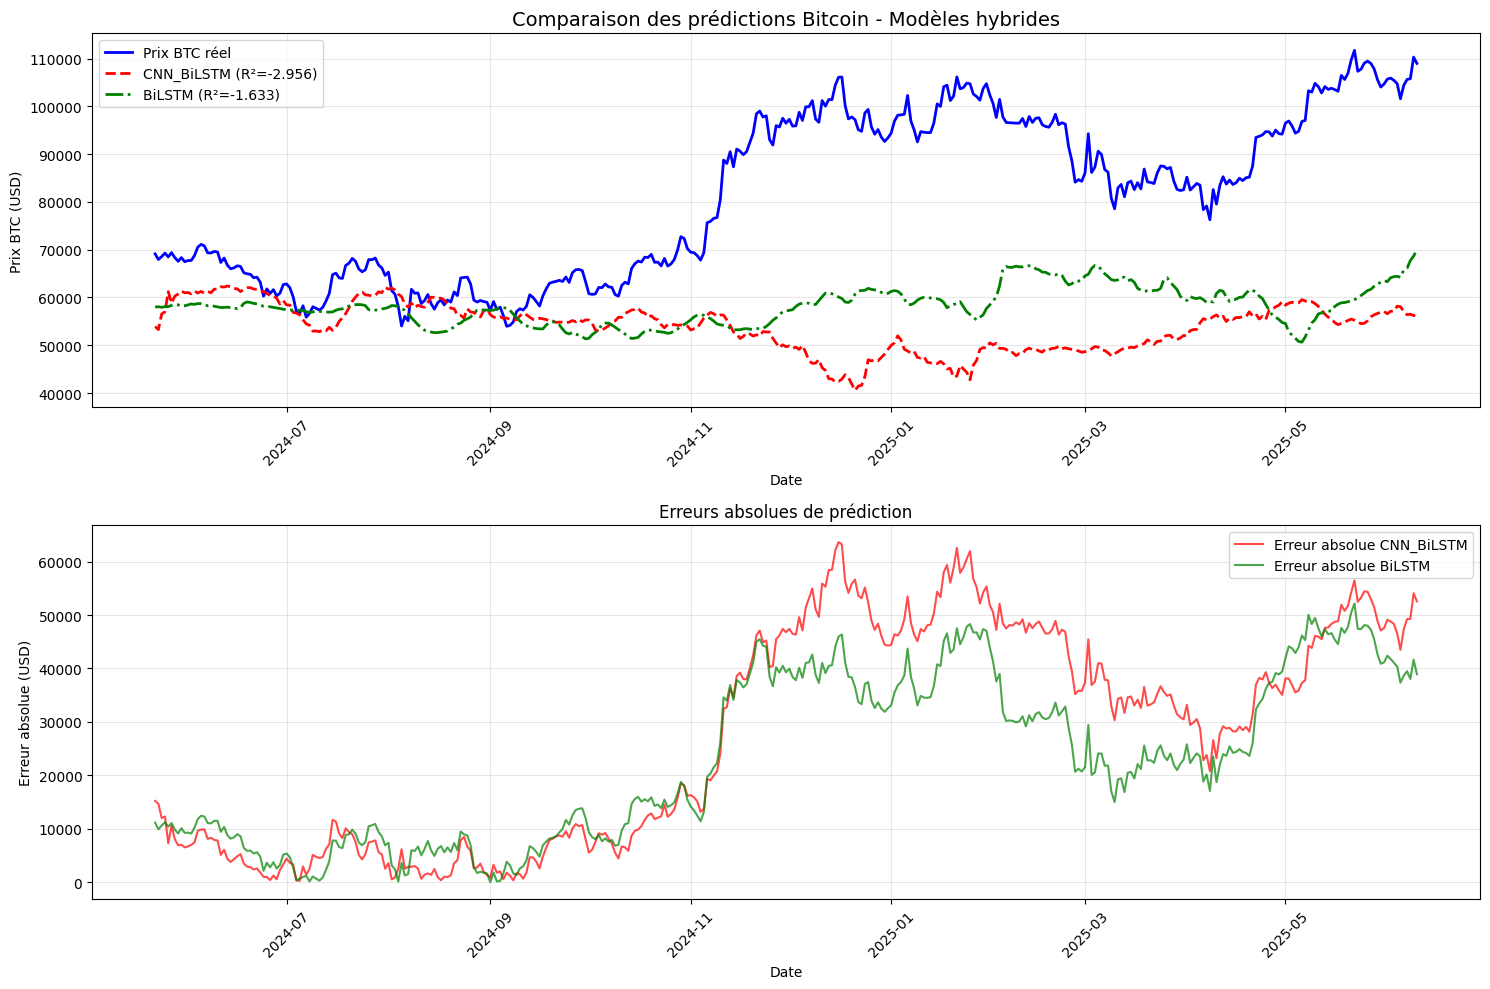

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



üèÜ Meilleur mod√®le: BiLSTM avec R¬≤ = -1.6327

üîÆ Pr√©diction des 7 prochains jours...
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 74ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 71ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 71ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 68ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 87ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 74ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 69ms/step
Prix BTC pr√©dits pour les 7 prochains jours:
Jour 1: $70335.76
Jour 2: $70417.09
Jour 3: $70522.95
Jour 4: $70246.86
Jour 5: $69942.36
Jour 6: $69619.41
Jour 7: $69456.02


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import time
from datetime import datetime
from keras.models import Sequential, load_model
from keras.layers import LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import requests

# Fonction de r√©cup√©ration de donn√©es (inchang√©e)
def collect_data_crypto_compare(crypto_symbol, start_timestamp, end_timestamp):
    url = f'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': crypto_symbol,
        'tsym': 'USD',
        'limit': 2000,
        'toTs': end_timestamp,
        'extraParams': 'crypto_prediction'
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()['Data']['Data']
        df = pd.DataFrame(data)
        df['time'] = pd.to_datetime(df['time'], unit='s')
        return df
    else:
        print(f"Erreur lors de la r√©cup√©ration des donn√©es: {response.status_code}")
        return None

# Pr√©traitement am√©lior√© avec plus de features
def preprocess_data(btc_df, eth_df):
    df = pd.merge(btc_df[['time', 'close', 'high', 'low', 'volumeto']],
                  eth_df[['time', 'close', 'high', 'low', 'volumeto']],
                  on='time', suffixes=('_btc', '_eth'))
    df = df.sort_values('time')

    # Features existantes
    df['btc_return'] = df['close_btc'].pct_change()
    df['eth_return'] = df['close_eth'].pct_change()

    # Nouvelles features techniques
    df['btc_volatility'] = df['btc_return'].rolling(window=7).std()
    df['eth_volatility'] = df['eth_return'].rolling(window=7).std()
    df['btc_rsi'] = calculate_rsi(df['close_btc'])
    df['eth_rsi'] = calculate_rsi(df['close_eth'])
    df['btc_ma_7'] = df['close_btc'].rolling(window=7).mean()
    df['btc_ma_21'] = df['close_btc'].rolling(window=21).mean()
    df['btc_volume_ma'] = df['volumeto_btc'].rolling(window=7).mean()

    # Ratio ETH/BTC
    df['eth_btc_ratio'] = df['close_eth'] / df['close_btc']

    df.dropna(inplace=True)
    return df

def calculate_rsi(prices, window=14):
    """Calcul du RSI (Relative Strength Index)"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Cr√©ation des s√©quences avec plus de features
def create_sequences_enhanced(data, seq_length=30):
    features = ['close_btc', 'close_eth', 'btc_return', 'eth_return',
                'btc_volatility', 'eth_volatility', 'btc_rsi', 'eth_rsi',
                'btc_ma_7', 'btc_ma_21', 'eth_btc_ratio', 'volumeto_btc']

    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data['close_btc'].iloc[i+seq_length])
    return np.array(X), np.array(y)

# Mod√®le hybride CNN + Bi-LSTM
def build_cnn_bilstm_model(seq_length, n_features, cnn_filters=64, lstm_units=128, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        # Couches CNN pour capturer les patterns locaux
        Conv1D(filters=cnn_filters, kernel_size=3, activation='relu', input_shape=(seq_length, n_features)),
        BatchNormalization(),
        Conv1D(filters=cnn_filters//2, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),

        # Couches Bi-LSTM pour capturer les d√©pendances temporelles
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Bidirectional(LSTM(lstm_units//2, return_sequences=False)),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Couches denses
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    return model

# Mod√®le Bi-LSTM pur
def build_bilstm_model(seq_length, n_features, lstm_units=128, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, return_sequences=True, input_shape=(seq_length, n_features))),
        BatchNormalization(),
        Dropout(dropout_rate),

        Bidirectional(LSTM(lstm_units//2, return_sequences=True)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Bidirectional(LSTM(lstm_units//4, return_sequences=False)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    return model

# Entra√Ænement avec les mod√®les hybrides
def train_hybrid_models(data):
    # Param√®tres optimis√©s
    best_params = {
        'seq_length': 60,
        'cnn_filters': 64,
        'lstm_units': 128,
        'dropout': 0.3,
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 150
    }

    # Normalisation des donn√©es
    features = ['close_btc', 'close_eth', 'btc_return', 'eth_return',
                'btc_volatility', 'eth_volatility', 'btc_rsi', 'eth_rsi',
                'btc_ma_7', 'btc_ma_21', 'eth_btc_ratio', 'volumeto_btc']

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[features])
    data_scaled_df = pd.DataFrame(data_scaled, columns=features, index=data.index)

    # Cr√©ation des s√©quences
    X, y = create_sequences_enhanced(data_scaled_df, best_params['seq_length'])

    # Division train/test
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
    checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

    models = {}
    predictions = {}

    # 1. Mod√®le CNN + Bi-LSTM
    print("üöÄ Entra√Ænement du mod√®le CNN + Bi-LSTM...")
    model_cnn_bilstm = build_cnn_bilstm_model(
        best_params['seq_length'],
        len(features),
        best_params['cnn_filters'],
        best_params['lstm_units'],
        best_params['dropout'],
        best_params['learning_rate']
    )

    history_cnn_bilstm = model_cnn_bilstm.fit(
        X_train, y_train,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_split=0.2,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    pred_cnn_bilstm = model_cnn_bilstm.predict(X_test)
    models['CNN_BiLSTM'] = model_cnn_bilstm
    predictions['CNN_BiLSTM'] = pred_cnn_bilstm

    # 2. Mod√®le Bi-LSTM pur
    print("üöÄ Entra√Ænement du mod√®le Bi-LSTM...")
    model_bilstm = build_bilstm_model(
        best_params['seq_length'],
        len(features),
        best_params['lstm_units'],
        best_params['dropout'],
        best_params['learning_rate']
    )

    history_bilstm = model_bilstm.fit(
        X_train, y_train,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_split=0.2,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    pred_bilstm = model_bilstm.predict(X_test)
    models['BiLSTM'] = model_bilstm
    predictions['BiLSTM'] = pred_bilstm

    # D√©normalisation des pr√©dictions
    btc_scaler = MinMaxScaler()
    btc_scaler.fit(data[['close_btc']])

    y_test_real = btc_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # √âvaluation des mod√®les
    results = {}
    for name, pred in predictions.items():
        pred_real = btc_scaler.inverse_transform(pred).flatten()

        mse = mean_squared_error(y_test_real, pred_real)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_real, pred_real)

        results[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'predictions': pred_real
        }

        print(f"\n‚úÖ {name} - MSE: {mse:.2f}, RMSE: {rmse:.2f}, R¬≤: {r2:.4f}")

    # Visualisation comparative
    test_dates = data['time'].iloc[-len(y_test):].values

    plt.figure(figsize=(15, 10))

    # Graphique principal
    plt.subplot(2, 1, 1)
    plt.plot(test_dates, y_test_real, label='Prix BTC r√©el', color='blue', linewidth=2)
    colors = ['red', 'green']
    linestyles = ['--', '-.']

    for i, (name, result) in enumerate(results.items()):
        plt.plot(test_dates, result['predictions'],
                label=f'{name} (R¬≤={result["R2"]:.3f})',
                color=colors[i], linestyle=linestyles[i], linewidth=2)

    plt.title('Comparaison des pr√©dictions Bitcoin - Mod√®les hybrides', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Prix BTC (USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # Graphique des erreurs
    plt.subplot(2, 1, 2)
    for i, (name, result) in enumerate(results.items()):
        errors = np.abs(y_test_real - result['predictions'])
        plt.plot(test_dates, errors, label=f'Erreur absolue {name}',
                color=colors[i], alpha=0.7)

    plt.title('Erreurs absolues de pr√©diction')
    plt.xlabel('Date')
    plt.ylabel('Erreur absolue (USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Sauvegarde du meilleur mod√®le
    best_model_name = max(results.keys(), key=lambda x: results[x]['R2'])
    best_model = models[best_model_name]
    best_model.save(f"best_{best_model_name.lower()}_model.h5")

    print(f"\nüèÜ Meilleur mod√®le: {best_model_name} avec R¬≤ = {results[best_model_name]['R2']:.4f}")

    return models, scaler, results

# Fonction de pr√©diction future
def predict_future_prices(model, scaler, last_sequence, n_days=7):
    """Pr√©dire les prix futurs"""
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_days):
        pred = model.predict(current_sequence.reshape(1, *current_sequence.shape))[0, 0]
        predictions.append(pred)

        # Mise √† jour de la s√©quence (sliding window)
        new_row = current_sequence[-1].copy()
        new_row[0] = pred  # Remplacer le prix BTC
        current_sequence = np.vstack([current_sequence[1:], new_row])

    return np.array(predictions)

# Utilisation principale
if __name__ == "__main__":
    print("üîÑ Collecte des donn√©es...")
    today = datetime.today()
    end_timestamp = int(time.mktime(today.timetuple()))
    start_timestamp = 1614556800  # 1er mars 2021

    btc_data = collect_data_crypto_compare('BTC', start_timestamp, end_timestamp)
    eth_data = collect_data_crypto_compare('ETH', start_timestamp, end_timestamp)

    if btc_data is not None and eth_data is not None:
        print("üìä Pr√©paration des donn√©es...")
        data = preprocess_data(btc_data, eth_data)

        print("ü§ñ Entra√Ænement des mod√®les hybrides...")
        models, scaler, results = train_hybrid_models(data)

        # Pr√©diction future (optionnel)
        print("\nüîÆ Pr√©diction des 7 prochains jours...")
        best_model_name = max(results.keys(), key=lambda x: results[x]['R2'])
        best_model = models[best_model_name]

        # Pr√©parer la derni√®re s√©quence
        features = ['close_btc', 'close_eth', 'btc_return', 'eth_return',
                    'btc_volatility', 'eth_volatility', 'btc_rsi', 'eth_rsi',
                    'btc_ma_7', 'btc_ma_21', 'eth_btc_ratio', 'volumeto_btc']

        last_sequence = scaler.transform(data[features].tail(60).values)
        future_predictions = predict_future_prices(best_model, scaler, last_sequence, 7)

        # D√©normaliser les pr√©dictions futures
        btc_scaler = MinMaxScaler()
        btc_scaler.fit(data[['close_btc']])
        future_prices = btc_scaler.inverse_transform(future_predictions.reshape(-1, 1)).flatten()

        print(f"Prix BTC pr√©dits pour les 7 prochains jours:")
        for i, price in enumerate(future_prices, 1):
            print(f"Jour {i}: ${price:.2f}")

    else:
        print("‚ùå Erreur : Les donn√©es n'ont pas pu √™tre r√©cup√©r√©es.")


üîç Total de combinaisons √† tester : 81

‚ú™ Test 1/81: seq=15, units=32, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000393

‚ú™ Test 2/81: seq=15, units=32, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000449

‚ú™ Test 3/81: seq=15, units=32, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000900

‚ú™ Test 4/81: seq=15, units=32, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000747

‚ú™ Test 5/81: seq=15, units=32, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000608

‚ú™ Test 6/81: seq=15, units=32, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001513

‚ú™ Test 7/81: seq=15, units=32, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001794

‚ú™ Test 8/81: seq=15, units=32, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000902

‚ú™ Test 9/81: seq=15, units=32, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.002315

‚ú™ Test 10/81: seq=15, units=64, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000349

‚ú™ Test 11/81: seq=15, units=64, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000425

‚ú™ Test 12/81: seq=15, units=64, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001118

‚ú™ Test 13/81: seq=15, units=64, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000368

‚ú™ Test 14/81: seq=15, units=64, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000968

‚ú™ Test 15/81: seq=15, units=64, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000877

‚ú™ Test 16/81: seq=15, units=64, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000424

‚ú™ Test 17/81: seq=15, units=64, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001170

‚ú™ Test 18/81: seq=15, units=64, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000819

‚ú™ Test 19/81: seq=15, units=128, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000473

‚ú™ Test 20/81: seq=15, units=128, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000311

‚ú™ Test 21/81: seq=15, units=128, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001946

‚ú™ Test 22/81: seq=15, units=128, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000330

‚ú™ Test 23/81: seq=15, units=128, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000286

‚ú™ Test 24/81: seq=15, units=128, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000833

‚ú™ Test 25/81: seq=15, units=128, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000577

‚ú™ Test 26/81: seq=15, units=128, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000411

‚ú™ Test 27/81: seq=15, units=128, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000908

‚ú™ Test 28/81: seq=30, units=32, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000322

‚ú™ Test 29/81: seq=30, units=32, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000495

‚ú™ Test 30/81: seq=30, units=32, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000977

‚ú™ Test 31/81: seq=30, units=32, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000461

‚ú™ Test 32/81: seq=30, units=32, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000558

‚ú™ Test 33/81: seq=30, units=32, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000944

‚ú™ Test 34/81: seq=30, units=32, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001829

‚ú™ Test 35/81: seq=30, units=32, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000512

‚ú™ Test 36/81: seq=30, units=32, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001122

‚ú™ Test 37/81: seq=30, units=64, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000364

‚ú™ Test 38/81: seq=30, units=64, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000326

‚ú™ Test 39/81: seq=30, units=64, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000503

‚ú™ Test 40/81: seq=30, units=64, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000363

‚ú™ Test 41/81: seq=30, units=64, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000362

‚ú™ Test 42/81: seq=30, units=64, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001138

‚ú™ Test 43/81: seq=30, units=64, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000369

‚ú™ Test 44/81: seq=30, units=64, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000533

‚ú™ Test 45/81: seq=30, units=64, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001373

‚ú™ Test 46/81: seq=30, units=128, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000262

‚ú™ Test 47/81: seq=30, units=128, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000347

‚ú™ Test 48/81: seq=30, units=128, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001008

‚ú™ Test 49/81: seq=30, units=128, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000331

‚ú™ Test 50/81: seq=30, units=128, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000314

‚ú™ Test 51/81: seq=30, units=128, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.002107

‚ú™ Test 52/81: seq=30, units=128, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000327

‚ú™ Test 53/81: seq=30, units=128, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000387

‚ú™ Test 54/81: seq=30, units=128, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001241

‚ú™ Test 55/81: seq=45, units=32, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000452

‚ú™ Test 56/81: seq=45, units=32, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000570

‚ú™ Test 57/81: seq=45, units=32, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001203

‚ú™ Test 58/81: seq=45, units=32, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000390

‚ú™ Test 59/81: seq=45, units=32, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000671

‚ú™ Test 60/81: seq=45, units=32, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001059

‚ú™ Test 61/81: seq=45, units=32, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001579

‚ú™ Test 62/81: seq=45, units=32, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000773

‚ú™ Test 63/81: seq=45, units=32, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001347

‚ú™ Test 64/81: seq=45, units=64, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000335

‚ú™ Test 65/81: seq=45, units=64, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000317

‚ú™ Test 66/81: seq=45, units=64, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000874

‚ú™ Test 67/81: seq=45, units=64, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000297

‚ú™ Test 68/81: seq=45, units=64, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000479

‚ú™ Test 69/81: seq=45, units=64, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001057

‚ú™ Test 70/81: seq=45, units=64, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000349

‚ú™ Test 71/81: seq=45, units=64, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001014

‚ú™ Test 72/81: seq=45, units=64, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001742

‚ú™ Test 73/81: seq=45, units=128, dropout=0.1, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000576

‚ú™ Test 74/81: seq=45, units=128, dropout=0.1, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000285

‚ú™ Test 75/81: seq=45, units=128, dropout=0.1, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000450

‚ú™ Test 76/81: seq=45, units=128, dropout=0.2, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000352

‚ú™ Test 77/81: seq=45, units=128, dropout=0.2, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000296

‚ú™ Test 78/81: seq=45, units=128, dropout=0.2, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000466

‚ú™ Test 79/81: seq=45, units=128, dropout=0.3, lr=0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000299

‚ú™ Test 80/81: seq=45, units=128, dropout=0.3, lr=0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.000361

‚ú™ Test 81/81: seq=45, units=128, dropout=0.3, lr=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


üìâ MSE moyen : 0.001507

‚úÖ Meilleure configuration trouv√©e : {'seq_length': 30, 'units': 128, 'dropout': 0.1, 'learning_rate': 0.01}
üìä Score MSE moyen : 0.000262
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 62ms/step - loss: 0.0375 - val_loss: 0.0013
Epoch 2/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 51ms/step - loss: 8.9541e-04 - val_loss: 2.2342e-04
Epoch 3/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 51ms/step - loss: 4.9596e-04 - val_loss: 3.9292e-04
Epoch 4/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 50ms/step - loss: 4.7087e-04 - val_loss: 4.6512e-04
Epoch 5/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 50ms/step - loss: 4.0904e-04 - val_loss: 2.3585e-04
Epoch 6/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 50ms/step - loss: 3.2002e-04 - val_loss: 3.3833e-04
Epoch 7/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 51ms/step - loss: 3.2942e-04 - val_loss: 4.4663e-04
Epoch 8/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 

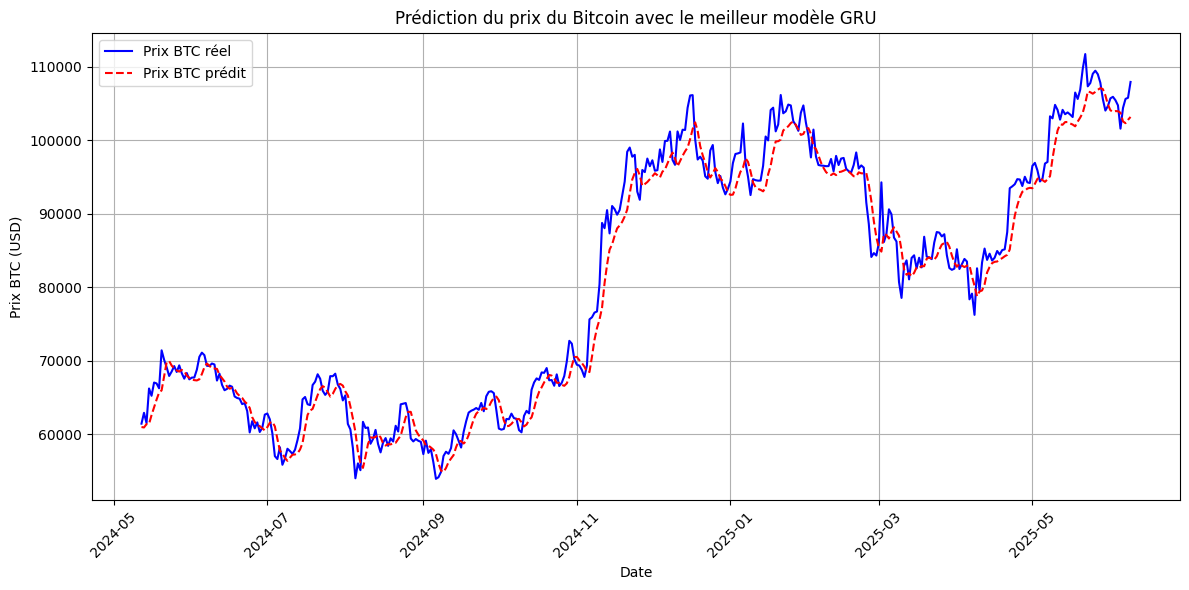

In [ ]:
# Ajout complet avec recherche automatique d'hyperparam√®tres (grid search), entrainement du meilleur mod√®le, et visualisation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import time
from datetime import datetime
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import itertools
import requests

# Fonctions inchang√©es pour la cr√©ation des s√©quences et le mod√®le
def collect_data_crypto_compare(crypto_symbol, start_timestamp, end_timestamp):
    url = f'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': crypto_symbol,  # Symbole de la cryptomonnaie (BTC ou ETH)
        'tsym': 'USD',  # Devise de comparaison
        'limit': 2000,  # Limite des jours √† r√©cup√©rer
        'toTs': end_timestamp,  # Timestamp de fin
        'extraParams': 'crypto_prediction'  # Param√®tre optionnel pour l'identification de l'application
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()['Data']['Data']
        df = pd.DataFrame(data)

        # Convertir les timestamps en dates lisibles
        df['time'] = pd.to_datetime(df['time'], unit='s')

        return df
    else:
        print(f"Erreur lors de la r√©cup√©ration des donn√©es: {response.status_code}")
        return None

# Fonction pour pr√©traiter les donn√©es
def preprocess_data(btc_df, eth_df):
    # Fusionner les donn√©es BTC et ETH sur la colonne 'time'
    df = pd.merge(btc_df[['time', 'close']], eth_df[['time', 'close']], on='time', suffixes=('_btc', '_eth'))

    # Conversion de la colonne time au format datetime si n√©cessaire
    if not pd.api.types.is_datetime64_any_dtype(df['time']):
        df['time'] = pd.to_datetime(df['time'])

    # Trier les donn√©es par ordre chronologique
    df = df.sort_values('time')

    # Calculer les retours journaliers pour BTC et ETH
    df['btc_return'] = df['close_btc'].pct_change()
    df['eth_return'] = df['close_eth'].pct_change()

    # Supprimer les lignes avec des valeurs NaN
    df.dropna(inplace=True)

    return df
def create_sequences(eth_prices, btc_prices, seq_length=30):
    X, y = [], []
    for i in range(len(eth_prices) - seq_length):
        X.append(np.column_stack((eth_prices[i:i+seq_length], btc_prices[i:i+seq_length])))
        y.append(btc_prices[i+seq_length])
    return np.array(X), np.array(y)

def build_gru_model(seq_length, units, dropout_rate, learning_rate):
    model = Sequential([
        GRU(units, return_sequences=True, input_shape=(seq_length, 2)),
        Dropout(dropout_rate),
        GRU(units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

def grid_search_gru(eth_scaled, btc_scaled):
    param_grid = {
        'seq_length': [15, 30, 45],
        'units': [32, 64, 128],
        'dropout': [0.1, 0.2, 0.3],
        'learning_rate': [0.01, 0.001, 0.0001]
    }
    best_score = float('inf')
    best_params = None
    combinations = list(itertools.product(*param_grid.values()))
    print(f"\nüîç Total de combinaisons √† tester : {len(combinations)}")

    for idx, (seq_length, units, dropout, lr) in enumerate(combinations):
        print(f"\n‚ú™ Test {idx+1}/{len(combinations)}: seq={seq_length}, units={units}, dropout={dropout}, lr={lr}")
        X, y = create_sequences(eth_scaled, btc_scaled, seq_length)
        X = X.reshape((X.shape[0], X.shape[1], 2))

        tscv = TimeSeriesSplit(n_splits=3)
        fold_scores = []

        for train_index, val_index in tscv.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model = build_gru_model(seq_length, units, dropout, lr)
            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

            model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=30, batch_size=32,
                callbacks=[early_stop], verbose=0
            )

            val_pred = model.predict(X_val, verbose=0)
            val_mse = mean_squared_error(y_val, val_pred)
            fold_scores.append(val_mse)
            del model
            gc.collect()

        avg_mse = np.mean(fold_scores)
        print(f"üìâ MSE moyen : {avg_mse:.6f}")

        if avg_mse < best_score:
            best_score = avg_mse
            best_params = {
                'seq_length': seq_length,
                'units': units,
                'dropout': dropout,
                'learning_rate': lr
            }

    print("\n‚úÖ Meilleure configuration trouv√©e :", best_params)
    print(f"üìä Score MSE moyen : {best_score:.6f}")
    return best_params

def train_best_gru_model(data, best_params):
    eth_scaler = MinMaxScaler()
    btc_scaler = MinMaxScaler()
    eth_scaled = eth_scaler.fit_transform(data[['close_eth']])
    btc_scaled = btc_scaler.fit_transform(data[['close_btc']])

    X, y = create_sequences(eth_scaled, btc_scaled, best_params['seq_length'])
    X = X.reshape((X.shape[0], X.shape[1], 2))

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = build_gru_model(
        best_params['seq_length'],
        best_params['units'],
        best_params['dropout'],
        best_params['learning_rate']
    )
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=100, batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    gru_pred = model.predict(X_test)
    y_test_btc = btc_scaler.inverse_transform(y_test)
    gru_pred_btc = btc_scaler.inverse_transform(gru_pred)

    mse = mean_squared_error(y_test_btc, gru_pred_btc)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_btc, gru_pred_btc)

    print(f"\nFinal Model Evaluation:\nMSE: {mse:.2f}, RMSE: {rmse:.2f}, R¬≤: {r2:.4f}")

    test_dates = data['time'].iloc[-len(y_test):].values
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test_btc, label='Prix BTC r√©el', color='blue')
    plt.plot(test_dates, gru_pred_btc, label='Prix BTC pr√©dit', color='red', linestyle='--')
    plt.title('Pr√©diction du prix du Bitcoin avec le meilleur mod√®le GRU')
    plt.xlabel('Date')
    plt.ylabel('Prix BTC (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return model, eth_scaler, btc_scaler

# Exemple d'utilisation avec des donn√©es collect√©es
today = datetime.today()
end_timestamp = int(time.mktime(today.timetuple()))
start_timestamp = 1614556800  # 1er mars 2021

btc_data = collect_data_crypto_compare('BTC', start_timestamp, end_timestamp)
eth_data = collect_data_crypto_compare('ETH', start_timestamp, end_timestamp)

if btc_data is not None and eth_data is not None:
    data = preprocess_data(btc_data, eth_data)
    best_params = grid_search_gru(
        MinMaxScaler().fit_transform(data[['close_eth']]),
        MinMaxScaler().fit_transform(data[['close_btc']])
    )
    model, eth_scaler, btc_scaler = train_best_gru_model(data, best_params)
else:
    print("Erreur : Les donn√©es n'ont pas pu √™tre r√©cup√©r√©es.")


Epoch 1/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 15s 193ms/step - loss: 0.6179 - val_loss: 0.0017
Epoch 2/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 136ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 3/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 137ms/step - loss: 0.0010 - val_loss: 5.1863e-04
Epoch 4/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 135ms/step - loss: 9.0838e-04 - val_loss: 0.0017
Epoch 5/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 153ms/step - loss: 0.0012 - val_loss: 3.0850e-04
Epoch 6/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 186ms/step - loss: 6.7032e-04 - val_loss: 2.9045e-04
Epoch 7/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 147ms/step - loss: 6.2842e-04 - val_loss: 2.8224e-04
Epoch 8/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

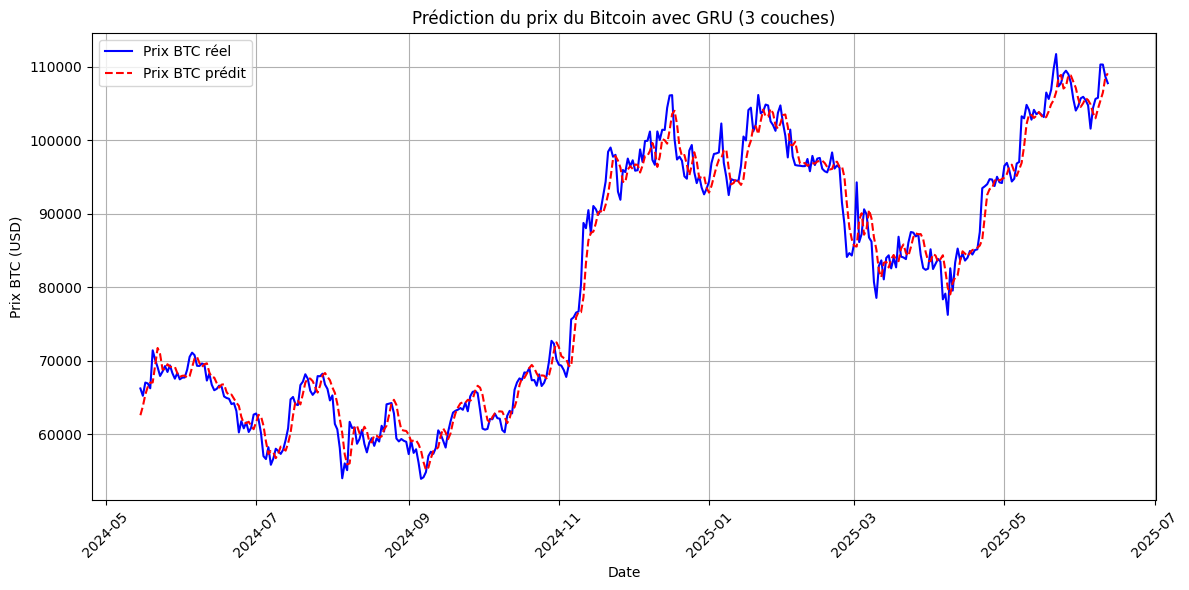

‚úÖ Mod√®le sauvegard√© sous le nom 'best_best_model.h5'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import requests

# ---------- 1. Collecte des donn√©es ----------
def collect_data_crypto_compare(crypto_symbol, start_timestamp, end_timestamp):
    url = f'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': crypto_symbol,
        'tsym': 'USD',
        'limit': 2000,
        'toTs': end_timestamp,
        'extraParams': 'crypto_prediction'
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['Data']['Data']
        df = pd.DataFrame(data)
        df['time'] = pd.to_datetime(df['time'], unit='s')
        return df
    else:
        print(f"Erreur lors de la r√©cup√©ration des donn√©es : {response.status_code}")
        return None

# ---------- 2. Pr√©traitement ----------
def preprocess_data(btc_df, eth_df):
    df = pd.merge(btc_df[['time', 'close']], eth_df[['time', 'close']], on='time', suffixes=('_btc', '_eth'))
    df = df.sort_values('time')
    df['btc_return'] = df['close_btc'].pct_change()
    df['eth_return'] = df['close_eth'].pct_change()
    df.dropna(inplace=True)
    return df

# ---------- 3. Cr√©ation des s√©quences ----------
def create_sequences(eth_prices, btc_prices, seq_length):
    X, y = [], []
    for i in range(len(eth_prices) - seq_length):
        X.append(np.column_stack((eth_prices[i:i+seq_length], btc_prices[i:i+seq_length])))
        y.append(btc_prices[i+seq_length])
    return np.array(X), np.array(y)

# ---------- 4. Construction du mod√®le GRU avec 3 couches ----------
def build_gru_model(seq_length, units=128, dropout=0.1, learning_rate=0.01):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=(seq_length, 2)))
    model.add(Dropout(dropout))
    model.add(GRU(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(units=units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# ---------- 5. Entra√Ænement et √âvaluation ----------
def train_gru_model(data, seq_length=32, units=128, dropout=0.1, learning_rate=0.01):
    eth_scaler = MinMaxScaler()
    btc_scaler = MinMaxScaler()
    eth_scaled = eth_scaler.fit_transform(data[['close_eth']])
    btc_scaled = btc_scaler.fit_transform(data[['close_btc']])

    X, y = create_sequences(eth_scaled, btc_scaled, seq_length)
    X = X.reshape((X.shape[0], X.shape[1], 2))

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = build_gru_model(seq_length, units, dropout, learning_rate)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    y_pred = model.predict(X_test)
    y_test_inv = btc_scaler.inverse_transform(y_test)
    y_pred_inv = btc_scaler.inverse_transform(y_pred)

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inv, y_pred_inv)

    print(f"\n√âvaluation finale du mod√®le GRU :")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R¬≤   : {r2:.4f}")

    # Visualisation
    test_dates = data['time'].iloc[-len(y_test):].values
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test_inv, label='Prix BTC r√©el', color='blue')
    plt.plot(test_dates, y_pred_inv, label='Prix BTC pr√©dit', color='red', linestyle='--')
    plt.title('Pr√©diction du prix du Bitcoin avec GRU (3 couches)')
    plt.xlabel('Date')
    plt.ylabel('Prix BTC (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Sauvegarde
    model.save("best_best_model.h5")
    print("‚úÖ Mod√®le sauvegard√© sous le nom 'best_best_model.h5'")
    return model

# ---------- 6. Ex√©cution ----------
if __name__ == "__main__":
    today = datetime.today()
    end_timestamp = int(time.mktime(today.timetuple()))
    start_timestamp = 1614556800  # 1 mars 2021

    btc_data = collect_data_crypto_compare('BTC', start_timestamp, end_timestamp)
    eth_data = collect_data_crypto_compare('ETH', start_timestamp, end_timestamp)

    if btc_data is not None and eth_data is not None:
        data = preprocess_data(btc_data, eth_data)
        model = train_gru_model(data)
    else:
        print("‚ùå Les donn√©es n'ont pas pu √™tre r√©cup√©r√©es.")


Epoch 1/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 46ms/step - loss: 0.0161 - val_loss: 2.2775e-04
Epoch 2/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 36ms/step - loss: 5.2792e-04 - val_loss: 2.8035e-04
Epoch 3/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 60ms/step - loss: 4.0025e-04 - val_loss: 1.9535e-04
Epoch 4/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 43ms/step - loss: 3.1749e-04 - val_loss: 2.0121e-04
Epoch 5/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 38ms/step - loss: 3.0800e-04 - val_loss: 1.8468e-04
Epoch 6/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 36ms/step - loss: 3.2659e-04 - val_loss: 3.8104e-04
Epoch 7/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 38ms/step - loss: 3.2679e-04 - val_loss: 2.7873e-04
Epoch 8/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

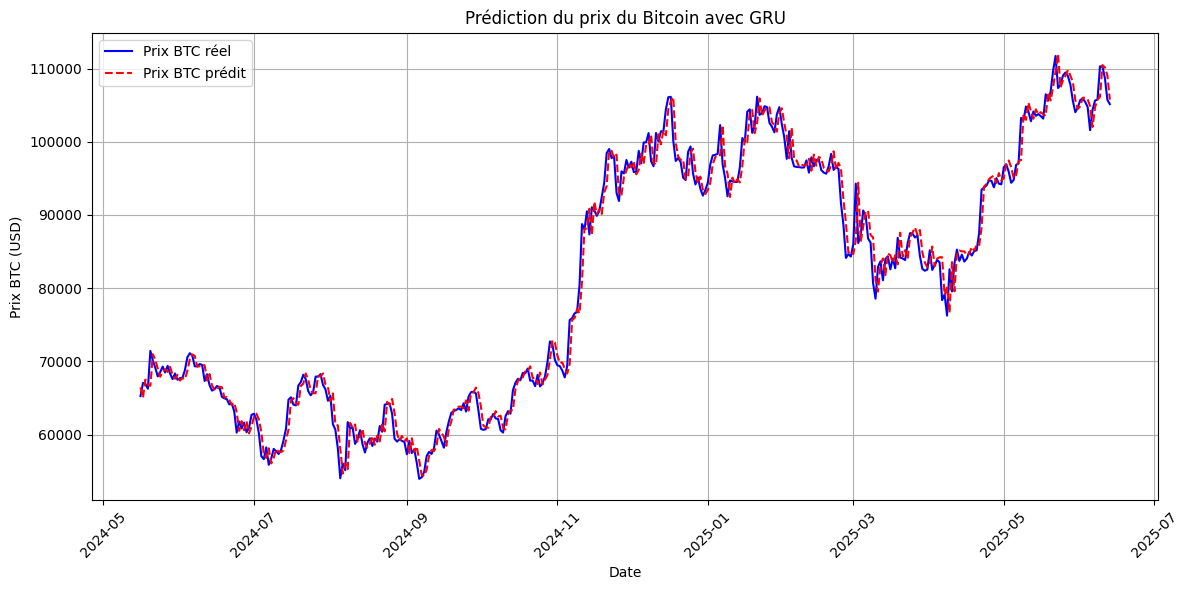

‚úÖ Mod√®le sauvegard√© sous le nom 'best_best_model.h5'


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import requests

# ---------- 1. Collecte des donn√©es ----------
def collect_data_crypto_compare(crypto_symbol, start_timestamp, end_timestamp):
    url = f'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': crypto_symbol,
        'tsym': 'USD',
        'limit': 2000,
        'toTs': end_timestamp,
        'extraParams': 'crypto_prediction'
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['Data']['Data']
        df = pd.DataFrame(data)
        df['time'] = pd.to_datetime(df['time'], unit='s')
        return df
    else:
        print(f"Erreur lors de la r√©cup√©ration des donn√©es : {response.status_code}")
        return None

# ---------- 2. Pr√©traitement ----------
def preprocess_data(btc_df, eth_df):
    df = pd.merge(btc_df[['time', 'close']], eth_df[['time', 'close']], on='time', suffixes=('_btc', '_eth'))
    df = df.sort_values('time')
    df['btc_return'] = df['close_btc'].pct_change()
    df['eth_return'] = df['close_eth'].pct_change()
    df.dropna(inplace=True)
    return df

# ---------- 3. Cr√©ation des s√©quences ----------
def create_sequences(eth_prices, btc_prices, seq_length):
    X, y = [], []
    for i in range(len(eth_prices) - seq_length):
        X.append(np.column_stack((eth_prices[i:i+seq_length], btc_prices[i:i+seq_length])))
        y.append(btc_prices[i+seq_length])
    return np.array(X), np.array(y)

# ---------- 4. Construction du mod√®le GRU ----------
def build_gru_model(seq_length, units=128, dropout=0.1, learning_rate=0.01):
    model = Sequential()
    model.add(GRU(units=units, input_shape=(seq_length, 2)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# ---------- 5. Entra√Ænement et √âvaluation ----------
def train_gru_model(data, seq_length=32, units=128, dropout=0.1, learning_rate=0.01):
    eth_scaler = MinMaxScaler()
    btc_scaler = MinMaxScaler()
    eth_scaled = eth_scaler.fit_transform(data[['close_eth']])
    btc_scaled = btc_scaler.fit_transform(data[['close_btc']])

    X, y = create_sequences(eth_scaled, btc_scaled, seq_length)
    X = X.reshape((X.shape[0], X.shape[1], 2))

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = build_gru_model(seq_length, units, dropout, learning_rate)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    y_pred = model.predict(X_test)
    y_test_inv = btc_scaler.inverse_transform(y_test)
    y_pred_inv = btc_scaler.inverse_transform(y_pred)

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inv, y_pred_inv)

    print(f"\n√âvaluation finale du mod√®le GRU :")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R¬≤   : {r2:.4f}")

    # Visualisation
    test_dates = data['time'].iloc[-len(y_test):].values
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test_inv, label='Prix BTC r√©el', color='blue')
    plt.plot(test_dates, y_pred_inv, label='Prix BTC pr√©dit', color='red', linestyle='--')
    plt.title('Pr√©diction du prix du Bitcoin avec GRU')
    plt.xlabel('Date')
    plt.ylabel('Prix BTC (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Sauvegarde
    model.save("best_best_model.h5")
    print("‚úÖ Mod√®le sauvegard√© sous le nom 'best_best_model.h5'")
    return model

# ---------- 6. Ex√©cution ----------
if __name__ == "__main__":
    today = datetime.today()
    end_timestamp = int(time.mktime(today.timetuple()))
    start_timestamp = 1614556800  # 1 mars 2021

    btc_data = collect_data_crypto_compare('BTC', start_timestamp, end_timestamp)
    eth_data = collect_data_crypto_compare('ETH', start_timestamp, end_timestamp)

    if btc_data is not None and eth_data is not None:
        data = preprocess_data(btc_data, eth_data)
        model = train_gru_model(data)
    else:
        print("‚ùå Les donn√©es n'ont pas pu √™tre r√©cup√©r√©es.")



In [13]:
pip install optuna


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 386.6/386.6 kB 7.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 242.5/242.5 kB 17.2 MB/s eta 0:00:00


In [16]:
import optuna

def objective(trial):
    seq_length = 32  # fixe, ou tu peux aussi le tuner
    units = trial.suggest_int('units', 32, 256)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = 50

    eth_scaler = MinMaxScaler()
    btc_scaler = MinMaxScaler()
    eth_scaled = eth_scaler.fit_transform(data[['close_eth']])
    btc_scaled = btc_scaler.fit_transform(data[['close_btc']])

    X, y = create_sequences(eth_scaled, btc_scaled, seq_length)
    X = X.reshape((X.shape[0], X.shape[1], 2))

    train_size = int(len(X) * 0.8)
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]

    model = build_gru_model(seq_length, units, dropout, learning_rate)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=0
    )

    val_loss = min(history.history['val_loss'])
    return val_loss  # on cherche √† minimiser la perte validation

if __name__ == "__main__":
    # tes √©tapes de collecte et preprocess ici ...
    btc_data = collect_data_crypto_compare('BTC', start_timestamp, end_timestamp)
    eth_data = collect_data_crypto_compare('ETH', start_timestamp, end_timestamp)

    if btc_data is not None and eth_data is not None:
        data = preprocess_data(btc_data, eth_data)

        # Cr√©ation d‚Äôune √©tude Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=30)

        print("Meilleurs param√®tres trouv√©s :", study.best_params)

        # Entra√Æne le mod√®le final avec les meilleurs param√®tres
        best_params = study.best_params
        model = build_gru_model(
            seq_length=32,
            units=best_params['units'],
            dropout=best_params['dropout'],
            learning_rate=best_params['learning_rate']
        )

        # Pr√©paration donn√©es compl√®te
        eth_scaler = MinMaxScaler()
        btc_scaler = MinMaxScaler()
        eth_scaled = eth_scaler.fit_transform(data[['close_eth']])
        btc_scaled = btc_scaler.fit_transform(data[['close_btc']])
        X, y = create_sequences(eth_scaled, btc_scaled, 32)
        X = X.reshape((X.shape[0], X.shape[1], 2))

        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=100, batch_size=best_params['batch_size'],
                  validation_split=0.2, callbacks=[early_stop], verbose=1)

        # Tu peux ensuite √©valuer et sauvegarder le mod√®le comme dans ta fonction originale


[I 2025-06-13 19:58:17,682] A new study created in memory with name: no-name-9350582b-633f-40ef-886d-c7479fa3afbd
[I 2025-06-13 19:59:28,004] Trial 0 finished with value: 0.0008626662893220782 and parameters: {'units': 141, 'dropout': 0.188935323823113, 'learning_rate': 6.573478776012409e-05, 'batch_size': 64}. Best is trial 0 with value: 0.0008626662893220782.
[I 2025-06-13 20:01:13,127] Trial 1 finished with value: 0.0005736217135563493 and parameters: {'units': 162, 'dropout': 0.05555193422777205, 'learning_rate': 0.0003119861252386956, 'batch_size': 64}. Best is trial 1 with value: 0.0005736217135563493.
[I 2025-06-13 20:01:41,831] Trial 2 finished with value: 0.0007461183704435825 and parameters: {'units': 49, 'dropout': 0.2928551009421438, 'learning_rate': 0.00029005343435771876, 'batch_size': 32}. Best is trial 1 with value: 0.0005736217135563493.
[I 2025-06-13 20:02:58,570] Trial 3 finished with value: 0.000982461147941649 and parameters: {'units': 188, 'dropout': 0.18978442687

Meilleurs param√®tres trouv√©s : {'units': 97, 'dropout': 0.25720604416417736, 'learning_rate': 0.009754018072743294, 'batch_size': 32}
Epoch 1/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 47ms/step - loss: 0.0187 - val_loss: 2.4381e-04
Epoch 2/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 35ms/step - loss: 8.5664e-04 - val_loss: 5.0012e-04
Epoch 3/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 30ms/step - loss: 7.2903e-04 - val_loss: 8.2130e-04
Epoch 4/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 29ms/step - loss: 6.3154e-04 - val_loss: 1.9750e-04
Epoch 5/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 29ms/step - loss: 5.6777e-04 - val_loss: 2.0597e-04
Epoch 6/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 27ms/step - loss: 5.1666e-04 - val_loss: 1.7436e-04
Epoch 7/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

Epoch 1/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 47ms/step - loss: 0.0218 - val_loss: 0.0019
Epoch 2/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 29ms/step - loss: 0.0010 - val_loss: 1.7841e-04
Epoch 3/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 29ms/step - loss: 5.0356e-04 - val_loss: 6.8883e-04
Epoch 4/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 28ms/step - loss: 6.4105e-04 - val_loss: 2.8627e-04
Epoch 5/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 31ms/step - loss: 5.2004e-04 - val_loss: 5.2593e-04
Epoch 6/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 30ms/step - loss: 5.4143e-04 - val_loss: 3.6832e-04
Epoch 7/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 30ms/step - loss: 5.4915e-04 - val_loss: 2.1169e-04
Epoch 8/100
40/40 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

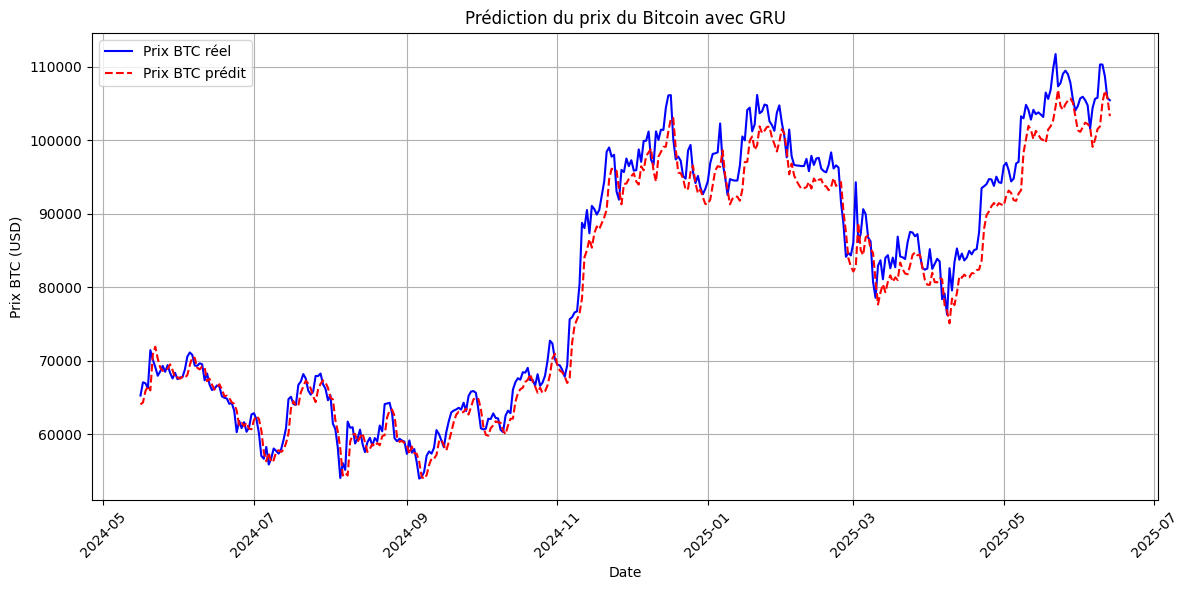

‚úÖ Mod√®le sauvegard√© sous le nom 'best_best_model.h5'


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import requests

# ---------- 1. Collecte des donn√©es ----------
def collect_data_crypto_compare(crypto_symbol, start_timestamp, end_timestamp):
    url = f'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': crypto_symbol,
        'tsym': 'USD',
        'limit': 2000,
        'toTs': end_timestamp,
        'extraParams': 'crypto_prediction'
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['Data']['Data']
        df = pd.DataFrame(data)
        df['time'] = pd.to_datetime(df['time'], unit='s')
        return df
    else:
        print(f"Erreur lors de la r√©cup√©ration des donn√©es : {response.status_code}")
        return None

# ---------- 2. Pr√©traitement ----------
def preprocess_data(btc_df, eth_df):
    df = pd.merge(btc_df[['time', 'close']], eth_df[['time', 'close']], on='time', suffixes=('_btc', '_eth'))
    df = df.sort_values('time')
    df['btc_return'] = df['close_btc'].pct_change()
    df['eth_return'] = df['close_eth'].pct_change()
    df.dropna(inplace=True)
    return df

# ---------- 3. Cr√©ation des s√©quences ----------
def create_sequences(eth_prices, btc_prices, seq_length):
    X, y = [], []
    for i in range(len(eth_prices) - seq_length):
        X.append(np.column_stack((eth_prices[i:i+seq_length], btc_prices[i:i+seq_length])))
        y.append(btc_prices[i+seq_length])
    return np.array(X), np.array(y)

# ---------- 4. Construction du mod√®le GRU ----------
def build_gru_model(seq_length, units=97, dropout=0.2572, learning_rate=0.009754):
    model = Sequential()
    model.add(GRU(units=units, input_shape=(seq_length, 2)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# ---------- 5. Entra√Ænement et √âvaluation ----------
def train_gru_model(data, seq_length=32):
    # Param√®tres optimaux
    units = 97
    dropout = 0.2572
    learning_rate = 0.009754
    batch_size = 32

    eth_scaler = MinMaxScaler()
    btc_scaler = MinMaxScaler()
    eth_scaled = eth_scaler.fit_transform(data[['close_eth']])
    btc_scaled = btc_scaler.fit_transform(data[['close_btc']])

    X, y = create_sequences(eth_scaled, btc_scaled, seq_length)
    X = X.reshape((X.shape[0], X.shape[1], 2))

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = build_gru_model(seq_length, units, dropout, learning_rate)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    y_pred = model.predict(X_test)
    y_test_inv = btc_scaler.inverse_transform(y_test)
    y_pred_inv = btc_scaler.inverse_transform(y_pred)

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inv, y_pred_inv)

    print(f"\n√âvaluation finale du mod√®le GRU :")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R¬≤   : {r2:.4f}")

    # Visualisation
    test_dates = data['time'].iloc[-len(y_test):].values
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test_inv, label='Prix BTC r√©el', color='blue')
    plt.plot(test_dates, y_pred_inv, label='Prix BTC pr√©dit', color='red', linestyle='--')
    plt.title('Pr√©diction du prix du Bitcoin avec GRU')
    plt.xlabel('Date')
    plt.ylabel('Prix BTC (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Sauvegarde
    model.save("best_best_model.h5")
    print("‚úÖ Mod√®le sauvegard√© sous le nom 'best_best_model.h5'")
    return model

# ---------- 6. Ex√©cution ----------
if __name__ == "__main__":
    today = datetime.today()
    end_timestamp = int(time.mktime(today.timetuple()))
    start_timestamp = 1614556800  # 1 mars 2021

    btc_data = collect_data_crypto_compare('BTC', start_timestamp, end_timestamp)
    eth_data = collect_data_crypto_compare('ETH', start_timestamp, end_timestamp)

    if btc_data is not None and eth_data is not None:
        data = preprocess_data(btc_data, eth_data)
        model = train_gru_model(data)
    else:
        print("‚ùå Les donn√©es n'ont pas pu √™tre r√©cup√©r√©es.")
